# **Extract the dataset.**

In [4]:
import zipfile
import os

# Assuming the uploaded file is named 'dataset.zip'
uploaded_zip_path = '/content/dataset.zip'
extract_path = '/content/NewDataSet'  # Path to extract the dataset

# Create the extract directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Dataset extracted to {extract_path}')


Dataset extracted to /content/NewDataSet


In [5]:
# List files in the extracted directory
extracted_files = os.listdir(extract_path)
print(f'Extracted files: {extracted_files}')


Extracted files: ['__MACOSX', 'dataset']


In [6]:
import shutil
from sklearn.model_selection import train_test_split

# Define paths
test_dir = '/content/NewDataSet/dataset/test'
train_dir = '/content/NewDataSet/dataset/train'
temp_train_dir = '/content/NewDataSet/dataset/temp_train'
temp_validation_dir = '/content/NewDataSet/dataset/temp_validation'

# Create temporary directories for split data
os.makedirs(temp_train_dir, exist_ok=True)
os.makedirs(temp_validation_dir, exist_ok=True)

# Function to split data into training and validation sets
def split_data(source_dir, train_dir, val_dir, train_size=0.7):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            train_images, val_images = train_test_split(images, train_size=train_size)

            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
            for image in val_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

# Split the test data into training and validation sets
split_data(test_dir, temp_train_dir, temp_validation_dir, train_size=0.7)


# **Q2**

In [8]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [10]:
!pip install --upgrade wandb

# **Q3**

In [72]:
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam
from wandb.integration.keras import WandbCallback
import wandb

In [77]:
import os
import wandb

# Set WANDB_API_KEY environment variable (replace 'your_api_key' with your actual API key)
os.environ['WANDB_API_KEY'] = '5237a13f8f1acba19960eff228299c80defa0a3d'

# Initialize wandb
wandb.login()
wandb.init(project="Q2", entity="praba00021")


train_data_dir = '/content/NewDataSet/dataset/temp_train'
test_data_dir = '/content/NewDataSet/dataset/test'
val_data_dir = '/content/NewDataSet/dataset/temp_validation'

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [78]:
# Set aside 10% of the training data for hyperparameter tuning
train_images = []
for class_name in os.listdir(train_data_dir):
    class_path = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_path):
        train_images.extend([os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))])

random.shuffle(train_images)
_, val_data = train_test_split(train_images, test_size=0.1, random_state=42)


In [79]:
# Prepare data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 284 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [80]:
# Define the model building function
def build_model(input_shape, num_classes, filters_per_layer, dropout_rate, use_batch_normalization):
    model = Sequential()
    for i, filters in enumerate(filters_per_layer):
        if i == 0:
            model.add(Conv2D(filters, (3, 3), padding='same', input_shape=input_shape))
        else:
            model.add(Conv2D(filters, (3, 3), padding='same'))

        if use_batch_normalization:
            model.add(BatchNormalization())

        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        if dropout_rate:
            model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [81]:
# Define hyperparameters to tune
filters_per_layer = [64, 64, 64, 64, 64]
dropout_rate = 0.3
use_batch_normalization = True

# Dictionary to store results for each optimizer
results = {}

In [83]:
from wandb.integration.keras import WandbCallback

In [85]:
# Train and evaluate models with different optimizers
optimizers = {'SGD': SGD(), 'SGD with Momentum': SGD(momentum=0.9), 'RMSprop': RMSprop(), 'Adagrad': Adagrad(), 'Adam': Adam()}
for opt_name, optimizer in optimizers.items():
    # Initialize Weights & Biases for each optimizer to keep the logs separate
    wandb.init(project="Q2", entity="praba00021", name=opt_name)

    # Build model
    model = build_model(input_shape=(64, 64, 3), num_classes=train_generator.num_classes, filters_per_layer=filters_per_layer, dropout_rate=dropout_rate, use_batch_normalization=use_batch_normalization)

    # Compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[WandbCallback()])

    # Store history
    results[opt_name] = history.history

    # End Weights & Biases run for the current optimizer
    wandb.finish()

Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 1.0261 - accuracy: 0.4965

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114259-8wxinigk/files/model-best)... Done. 0.0s


9/9 [==============================] - 13s 1s/step - loss: 1.0261 - accuracy: 0.4965 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 6s 654ms/step - loss: 0.8669 - accuracy: 0.5070 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 8s 862ms/step - loss: 0.9560 - accuracy: 0.4930 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 6s 666ms/step - loss: 0.7751 - accuracy: 0.5493 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 5/10
9/9 [==============================] - 7s 813ms/step - loss: 0.8513 - accuracy: 0.5528 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 6s 644ms/step - loss: 0.6946 - accuracy: 0.5915 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.5176

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114259-8wxinigk/files/model-best)... Done. 0.0s


9/9 [==============================] - 59s 7s/step - loss: 0.7846 - accuracy: 0.5176 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 8/10
9/9 [==============================] - 6s 695ms/step - loss: 0.7531 - accuracy: 0.5739 - val_loss: 0.7040 - val_accuracy: 0.5000
Epoch 9/10
9/9 [==============================] - 8s 822ms/step - loss: 0.7690 - accuracy: 0.5246 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 10/10
9/9 [==============================] - 6s 700ms/step - loss: 0.7948 - accuracy: 0.5282 - val_loss: 0.7038 - val_accuracy: 0.5000


accuracy,▁▂▁▅▅█▃▇▃▄
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▇▃▄▁▃▂▃▃
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▃▃▂▂▁█▅█
accuracy,0.52817
best_epoch,6
best_val_loss,0.69446
epoch,9
loss,0.79478
val_accuracy,0.5


Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 1.0336 - accuracy: 0.4472

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114525-ixq11icb/files/model-best)... Done. 0.0s


9/9 [==============================] - 12s 1s/step - loss: 1.0336 - accuracy: 0.4472 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.5282

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114525-ixq11icb/files/model-best)... Done. 0.0s


9/9 [==============================] - 10s 1s/step - loss: 0.9527 - accuracy: 0.5282 - val_loss: 0.6906 - val_accuracy: 0.5484
Epoch 3/10
9/9 [==============================] - 8s 809ms/step - loss: 0.7946 - accuracy: 0.5775 - val_loss: 0.6947 - val_accuracy: 0.5403
Epoch 4/10
9/9 [==============================] - 6s 679ms/step - loss: 0.7386 - accuracy: 0.5704 - val_loss: 0.6949 - val_accuracy: 0.5484
Epoch 5/10
9/9 [==============================] - 8s 875ms/step - loss: 0.7116 - accuracy: 0.5704 - val_loss: 0.6907 - val_accuracy: 0.5565
Epoch 6/10
9/9 [==============================] - 6s 667ms/step - loss: 0.7388 - accuracy: 0.5035 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 6s 667ms/step - loss: 0.7240 - accuracy: 0.5458 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 8/10
9/9 [==============================] - 7s 826ms/step - loss: 0.7317 - accuracy: 0.5317 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 9/10
9/9 [=================

accuracy,▁▅▇▇▇▄▆▅█▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▃▂▂▂▂▂▁▂
val_accuracy,▁▇▆▇█▁▁▁▁▁
val_loss,▁▁▂▂▁▄▄▂█▇
accuracy,0.5493
best_epoch,1
best_val_loss,0.69057
epoch,9
loss,0.70795
val_accuracy,0.5


Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 1.8244 - accuracy: 0.4789

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114700-8051vflm/files/model-best)... Done. 0.0s


9/9 [==============================] - 14s 1s/step - loss: 1.8244 - accuracy: 0.4789 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.5352

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114700-8051vflm/files/model-best)... Done. 0.0s


9/9 [==============================] - 11s 1s/step - loss: 0.7947 - accuracy: 0.5352 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 6s 634ms/step - loss: 0.7851 - accuracy: 0.5493 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 7s 794ms/step - loss: 0.8202 - accuracy: 0.5458 - val_loss: 0.7257 - val_accuracy: 0.5000
Epoch 5/10
9/9 [==============================] - 6s 646ms/step - loss: 0.8341 - accuracy: 0.5423 - val_loss: 0.7024 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 8s 851ms/step - loss: 0.7309 - accuracy: 0.5951 - val_loss: 0.7969 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 5s 594ms/step - loss: 0.7671 - accuracy: 0.5634 - val_loss: 0.7128 - val_accuracy: 0.5000
Epoch 8/10
9/9 [==============================] - 7s 791ms/step - loss: 0.6995 - accuracy: 0.6021 - val_loss: 0.7881 - val_accuracy: 0.5000
Epoch 9/10
9/9 [=================

accuracy,▁▄▄▄▄▆▅▇█▄
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▁▂▁▁▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▂▁▅▂▄█▄
accuracy,0.53873
best_epoch,1
best_val_loss,0.69288
epoch,9
loss,0.80764
val_accuracy,0.5


Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 0.8860 - accuracy: 0.4754

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114834-00s4faul/files/model-best)... Done. 0.0s


9/9 [==============================] - 12s 1s/step - loss: 0.8860 - accuracy: 0.4754 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 6s 613ms/step - loss: 0.7993 - accuracy: 0.4859 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 8s 896ms/step - loss: 0.8074 - accuracy: 0.5282 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 6s 655ms/step - loss: 0.8368 - accuracy: 0.5035 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 5/10
9/9 [==============================] - 7s 829ms/step - loss: 0.8019 - accuracy: 0.5070 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 5s 574ms/step - loss: 0.8353 - accuracy: 0.4683 - val_loss: 0.7014 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 7s 770ms/step - loss: 0.8175 - accuracy: 0.4718 - val_loss: 0.7020 - val_accuracy: 0.5000
Epoch 8/10
9/9 [=================

accuracy,▂▂▆▄▄▁▁▅▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▅▆▅▆▅▃▃▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▃▂▅▅▅██
accuracy,0.55986
best_epoch,0
best_val_loss,0.69499
epoch,9
loss,0.712
val_accuracy,0.5


Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.5035

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114959-5myri1nh/files/model-best)... Done. 0.0s


9/9 [==============================] - 14s 1s/step - loss: 1.0868 - accuracy: 0.5035 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 1.1221 - accuracy: 0.5387

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114959-5myri1nh/files/model-best)... Done. 0.0s


9/9 [==============================] - 13s 1s/step - loss: 1.1221 - accuracy: 0.5387 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.5704

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240528_114959-5myri1nh/files/model-best)... Done. 0.0s


9/9 [==============================] - 11s 1s/step - loss: 0.8845 - accuracy: 0.5704 - val_loss: 0.6904 - val_accuracy: 0.5565
Epoch 4/10
9/9 [==============================] - 6s 685ms/step - loss: 0.7522 - accuracy: 0.5634 - val_loss: 0.6915 - val_accuracy: 0.5565
Epoch 5/10
9/9 [==============================] - 8s 849ms/step - loss: 0.7850 - accuracy: 0.5528 - val_loss: 0.7139 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 6s 698ms/step - loss: 0.7228 - accuracy: 0.5387 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 8s 931ms/step - loss: 0.6952 - accuracy: 0.5458 - val_loss: 0.7184 - val_accuracy: 0.5000
Epoch 8/10
9/9 [==============================] - 6s 659ms/step - loss: 0.6482 - accuracy: 0.6373 - val_loss: 0.7492 - val_accuracy: 0.5000
Epoch 9/10
9/9 [==============================] - 8s 914ms/step - loss: 0.6839 - accuracy: 0.5951 - val_loss: 0.7525 - val_accuracy: 0.5000
Epoch 10/10
9/9 [================

accuracy,▁▃▅▄▄▃▃█▆▅
epoch,▁▂▃▃▄▅▆▆▇█
loss,▇█▄▃▃▂▂▁▂▂
val_accuracy,▁▁██▁▁▁▁▁▁
val_loss,▁▁▁▁▄▂▄██▆
accuracy,0.58099
best_epoch,2
best_val_loss,0.69038
epoch,9
loss,0.68411
val_accuracy,0.5


In [87]:
# Print final validation accuracy for each optimizer
for opt_name, history in results.items():
    final_val_accuracy = history['val_accuracy'][-1]
    print(f"Final validation accuracy with {opt_name}: {final_val_accuracy:.4f}")

Final validation accuracy with SGD: 0.5000
Final validation accuracy with SGD with Momentum: 0.5000
Final validation accuracy with RMSprop: 0.5000
Final validation accuracy with Adagrad: 0.5000
Final validation accuracy with Adam: 0.5000


In [88]:
# Select the best optimizer based on the highest final validation accuracy
best_optimizer = max(results, key=lambda opt: results[opt]['val_accuracy'][-1])


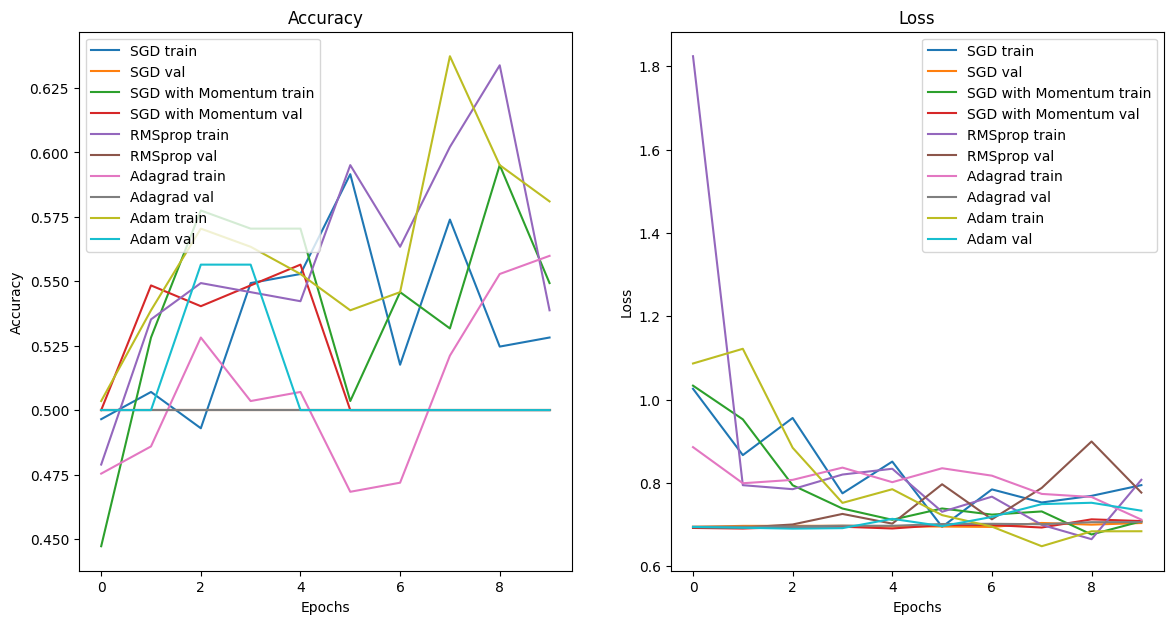

In [89]:
# Plot accuracy and loss curves
plt.figure(figsize=(14, 7))

# Plot accuracy
plt.subplot(1, 2, 1)
for opt_name, history in results.items():
    plt.plot(history['accuracy'], label=f'{opt_name} train')
    plt.plot(history['val_accuracy'], label=f'{opt_name} val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
for opt_name, history in results.items():
    plt.plot(history['loss'], label=f'{opt_name} train')
    plt.plot(history['val_loss'], label=f'{opt_name} val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [90]:
# Discussion of results
print(f"Best optimizer: {best_optimizer}")

Best optimizer: SGD
